## Sophia Bevans
## Replication of Figures 3, 5, and 6: 
### "Antibiotic exposure perturbs the gut microbiota and elevates mortality in honeybees"
Kasie Raymann,  Zack Shaffer,  Nancy A. Moran. 2017. PLOS  
https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2001861

_______

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import skbio
import skbio.stats.ordination as on
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import ranksums
import re
import warnings
warnings.filterwarnings("ignore")

________

## Figure 3: Alpha and beta diversity of treatment and control bees

In [2]:
class alpha_beta_div:
    "process alpha and beta diversity scores from relative abundance dataframe"
    
    def __init__(self, df, days):
        self.data = self.process_data(df) #re-structure dataframe
        self.days = days #time points data was taken

    def process_data(self, df):
        "process the dataframe for grouping into control, treatment, and time subgroups"
        df.columns = df.iloc[1, :]
        df = df.transpose()
        df.columns = df.iloc[0, :]
        df = df.iloc[1:, :]
        return df
    
    def split(self, data):
        """split into control and treatment groups, and into subgroups by day"""
        #control and treatment group dataframes 
        control_df = data.filter(like = "HC") 
        treatment_df = data.filter(like = "HT")
        #treatment subgroups for each day
        c_days = {f"Day{i}" : control_df.filter(regex = f".*_.*{i}") for i in self.days}
        t_days = {f"Day{i}" : treatment_df.filter(regex = f".*_.*{i}") for i in self.days}
        return [c_days, t_days]
    
    def calc_diversity(self, column):
        """helper method for calculating shannon's h index. H score is the sum of the 
        product of the relative abundance and the natural log of the relative abundance"""
        score = 0
        for proportion in column:
            if proportion != 0:
                score += (proportion * np.log(proportion))
        return score * -1
        
    def shannon_h(self):
        """Calculate alpha diversity (shannon's H scores) for each sample on each day"""
        #calculate shannon diversity within control and treatment groups
        for i, j in zip(self.split(self.data),['c', 't']):
            sh_d_scores = {}
            for d in i: #for each sampled day
                scores = []
                for column in i[d]: #calculate diversity for each sample
                    sc = self.calc_diversity(i[d][str(column)])
                    scores.append(sc)
                sh_d_scores[d] = scores
            #save scores from control and treatment groups
            if j == 'c': 
                self.c_sh_scores = sh_d_scores
            elif j == 't':
                self.t_sh_scores = sh_d_scores
    
    def bray_curtis_calc(self):
        """calculate bray-curtis dissimilarity matrix. the bc score between two arrays is the sum of the
        absolute differences divided by the sum of the absolute sums for i in each array"""
        df = self.data.to_numpy().transpose()
        data = [i.tolist() for i in df]
        bc_dm = pdist(data, "braycurtis")
        bc_dm = squareform(bc_dm)
        new_df = pd.DataFrame(bc_dm, columns = self.data.columns)
        return new_df

### Process data and calculate alpha diversity (Shannon's H scores) and beta diversity (Bray-Curtis dissimilarity)

In [3]:
#Original relative abundance data frame
rel_abundance = pd.read_csv("../data/s2_relative_abundance.csv")
rel_abundance.head()

,Sample ID,Alpha 2.1,Halomonadaceae,Bartonella,Bifidobacterium,Klebsiella,Serratia,Frischella,Gilliamella,Zymobacter,Fructobacillus,Lactobacillus Firm_4,Lactobacillus Firm_5,Lactobacillus kunkeei,Snodgrassella
0,HC1_0,0.0004,0.0,0.0004,0.1980,0.0000,0.0014,0.0000,0.2636,0.0,0.0000,0.0492,0.4652,0.0000,0.0218
1,HC10_0,0.0000,0.0,0.0002,0.0570,0.0002,0.0002,0.0012,0.1056,0.0,0.0066,0.1494,0.6314,0.0000,0.0482
2,HC11_0,0.0074,0.0,0.0000,0.0998,0.0000,0.0000,0.0004,0.2020,0.0,0.0002,0.0728,0.5930,0.0004,0.0240
3,HC12_0,0.0086,0.0,0.4662,0.0600,0.0000,0.0000,0.0000,0.0636,0.0,0.0022,0.0332,0.2832,0.0000,0.0830
4,HC13_0,0.0188,0.0,0.2440,0.0906,0.0000,0.0000,0.0000,0.1406,0.0,0.0020,0.0348,0.2968,0.0000,0.1718


In [16]:
days = [0, 3, 5, 7]  #time points data was taken for each bee
diversity_data = alpha_beta_div(rel_abundance, days) #create a diversity_data object
diversity_data.shannon_h() #shannon method (saves H values as attribute)
bc = diversity_data.bray_curtis_calc() #bray curtis method (returns a df)
bc_days = diversity_data.split(bc) #split by control/treatment and time points

#shannon diversity and bray curtis scores for control and treatment groups
control_sh = [diversity_data.c_sh_scores[i] for i in diversity_data.c_sh_scores]
treatment_sh = [diversity_data.t_sh_scores[i] for i in diversity_data.t_sh_scores]
control_bc = [np.concatenate(bc_days[0][i].to_numpy()) for i in bc_days[0]]
treatment_bc = [np.concatenate(bc_days[1][i].to_numpy()) for i in bc_days[1]]
control_bc = [a[a!=0] for a in control_bc]
treatment_bc = [a[a!=0] for a in treatment_bc]

In [17]:
#calculate wilcoxon rank sum p values

wilcoxon_rs_sh = [ranksums(control_sh[i], treatment_sh[i]).pvalue for i in range(len(control_sh))]
wilcoxon_rs_bc = [ranksums(control_bc[i], treatment_bc[i]).pvalue for i in range(len(control_bc))]
print("p-values alpha diversity (Day0, Day3, Day5, Day7):\n", *wilcoxon_rs_sh, "\n")
print("p-values beta diversity (Day0, Day3, Day5, Day7):\n", *wilcoxon_rs_bc)


# prepare text for significance annotation of plots

def significance_text(p_vals):
    """create list of significance value annotations for wilcoxon p values
    not significant = empty string """
    sig = []
    for i in p_vals:
        if i < 0.0001:
            sig.append("***")
        elif i < 0.05:
            sig.append("*")
        else:
            sig.append("")
    return sig

wrs_sh = significance_text(wilcoxon_rs_sh)
wrs_bc = significance_text(wilcoxon_rs_bc)

p-values alpha diversity (Day0, Day3, Day5, Day7):
 0.8614141344963563 8.472749912498592e-05 6.26412892627612e-05 0.002600401438617244 

p-values beta diversity (Day0, Day3, Day5, Day7):
 0.5893682138755181 8.107951507991389e-139 8.331781735894568e-138 1.1899533827411174e-20


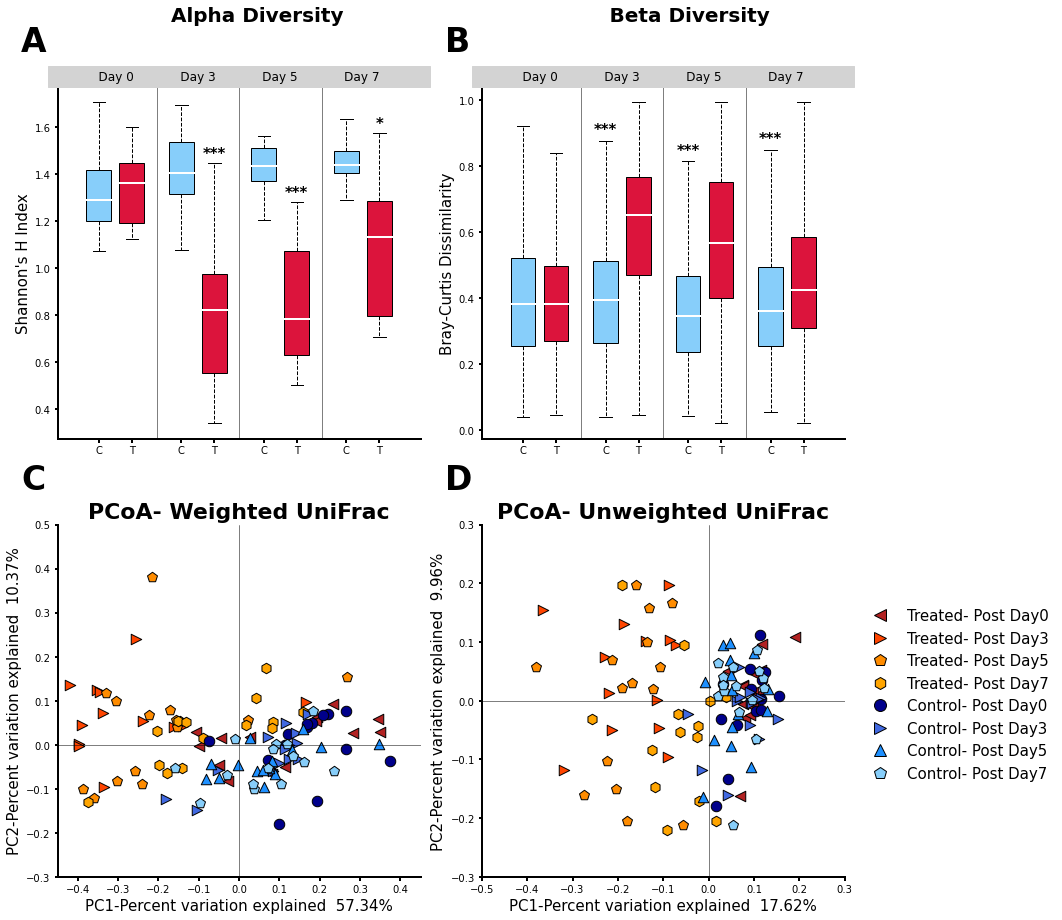

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 13))

## alpha and beta diversity plots
text_locs = {}
#control and treatment boxplots for subplot A and B
names = ["csh_bplot", "tsh_bplot", "cbc_bplot", "tbc_bplot"] 
i = 0
#offset control and treatment boxplots for side by side comparison
c_xlocs = np.arange(1, 5) - 0.2 
t_xlocs = np.arange(1, 5) + .2

#plot control and treatment boxplots for shannon and bray curtis scores
for a, c, t in zip(ax[0], [control_sh, control_bc], [treatment_sh, treatment_bc]):

    bplot1 = a.boxplot(c, sym = '', positions = c_xlocs, widths = 0.3, 
                       patch_artist = True, whiskerprops = dict(linestyle = '--'), 
                       medianprops = dict(color = 'white', linewidth = 2))
    bplot2 = a.boxplot(t, sym = '', positions = t_xlocs, widths = 0.3, 
                       patch_artist = True, whiskerprops = dict(linestyle = '--'), 
                       medianprops = dict(color = 'white', linewidth = 2))
    
    #save plot maximum for text annotation of pvalue significance
    mask = np.array([0, 1] * 4, dtype = bool)
    loc = []
    for j in bplot1["whiskers"]:
        loc.append(j.get_data()[1][1] + 0.02)
    text_locs[names[i]] = np.array(loc)[mask]
    i += 1
    loc = []
    for j in bplot2["whiskers"]:
        loc.append(j.get_data()[1][1] + 0.02)
    text_locs[names[i]] = np.array(loc)[mask]
    i += 1
    
    a.set_xticklabels(["C"] * 4 + ["T"] * 4)
    space = ' ' * 12
    a.set_title(f"{space}Day 0{space}Day 3{space}Day 5{space}Day 7{space}", backgroundcolor = "lightgrey")
    
    a.axvline(1.5, color = "black", linewidth = 0.5)
    a.axvline(2.5, color = "black", linewidth = 0.5)
    a.axvline(3.5, color = "black", linewidth = 0.5)

    for b in bplot1["boxes"]:
        b.set_facecolor('lightskyblue')
    for b in bplot2["boxes"]:
        b.set_facecolor('crimson')
        
#annotate boxes with p values indicating significance
for loc in range(len(text_locs["tsh_bplot"])):
    x = t_xlocs[loc] 
    y = text_locs["tsh_bplot"][loc]
    lab = wrs_sh[loc]
    ax[0][0].text(x, y, lab, fontdict = {"fontweight" : "bold", "fontsize" : 15, 
                                         "horizontalalignment" : "center"})
for loc in range(len(text_locs["cbc_bplot"])):
    x = c_xlocs[loc] 
    y = text_locs["cbc_bplot"][loc]
    lab = wrs_bc[loc]
    ax[0][1].text(x, y, lab, fontdict = {"fontweight" : "bold", "fontsize" : 15, 
                                         "horizontalalignment" : "center"})

#plot labels and specifications
ax[0][0].set_ylabel("Shannon's H Index", fontsize = 15)
ax[0][1].set_ylabel("Bray-Curtis Dissimilarity", fontsize = 15)

space = ' ' * 19
plt.suptitle(f"{space}Alpha Diversity{space}{space}Beta Diversity{space}{space}", 
             fontsize = 20, fontweight = "bold")

###PCoA analyis and plots

weightedDM = pd.read_csv("../data/weighted_unifrac_DM.csv")
unweightedDM = pd.read_csv("../data/unweighted_unifrac_DM.csv")
unweighted = unweightedDM.iloc[:, 1:]
weighted = weightedDM.iloc[:, 1:]

def map_index(df):
    """create and return index map of colors for sample groups in PCoA plot."""
    idx = ['0', '3', '5', '7']
    tc = ["firebrick", "orangered", "darkorange", "orange"]
    cc = ["darkblue", "royalblue", "dodgerblue", "lightskyblue"]
    colors = []

    i = 0
    for site in df.columns:
        if re.match("HT", site):
            colors.append(tc[idx.index(site[-1])])
        elif re.match("HC", site):
            colors.append(cc[idx.index(site[-1])])
        else:
            colors.append('black')
        i += 1
    return np.array(colors)

#marker colors
colors = ["firebrick", "orangered", "darkorange", "orange", 
              "darkblue", "royalblue", "dodgerblue", "lightskyblue"]
#group labels
labels = ['Treated- Post Day0', 'Treated- Post Day3', 'Treated- Post Day5', 'Treated- Post Day7', 
         'Control- Post Day0', 'Control- Post Day3', 'Control- Post Day5', 'Control- Post Day7']
shapes =  ["<", ">", "p", "h", "o", ">", "^", "p"]
rows = 2
cols = 2

def plot_pcoa_points(
    axis, x_vals, y_vals, colormap, 
    colors = colors, labels = labels, shapes = shapes):
    """Helper function for plotting pcoa points"""
    for i in range(len(colors)):
        idxs = np.where(colormap == colors[i])
        axis.scatter(x_vals.iloc[idxs], y_vals.iloc[idxs], c = colors[i], marker = shapes[i], 
                     label = labels[i], edgecolors = 'black', s = 110)

c = map_index(weighted) #color mapping

for d, a, t in zip((weighted, unweighted), ax[1], ["Weighted", "Unweighted"]):
    pcoa_results = pcoa(d) #PCoA results
    data = pcoa_results.samples  #sample positions
    prop_expl = pcoa_results.proportion_explained #proportion explained by dimensions
    if t == "Weighted":
        plot_pcoa_points(a, data[["PC1"]] * -1, data[['PC2']], c)
    elif t == "Unweighted":
        plot_pcoa_points(a, data[["PC1"]], data[['PC2']] * -1, c)
    #plot specifications
    a.set_xlabel(f"PC1-Percent variation explained {prop_expl[0] * 100 : .2f}%", fontsize = 15)
    a.set_ylabel(f"PC2-Percent variation explained {prop_expl[1] * 100 : .2f}%", fontsize = 15)
    a.set_title(f"PCoA- {t} UniFrac", fontsize = 22, fontweight = "bold")
    a.axhline(color = "black", linewidth = 0.5)
    a.axvline(color = "black", linewidth = 0.5)
    
#plot legend
marker_specs = [mlines.Line2D([], [], color = colors[i], label = labels[i], 
                              marker = shapes[i], markeredgecolor = 'black')for i in range(len(colors))]
leg = ax[1][1].legend(handles= marker_specs, bbox_to_anchor=(1.6, 0.8), markerscale = 2, 
                fontsize = 15, frameon = False)
for line in leg.get_lines():
    line.set_linewidth(0)


#weighted subplot axis limits
ax[1][0].set_xlim(left = -0.45, right = 0.45)
ax[1][0].set_ylim(bottom = -0.3, top = 0.5)

#unweighted subplot axis limits
ax[1][1].set_xlim(left = -0.5, right = 0.3)
ax[1][1].set_ylim(bottom = -0.3, top = 0.3)

#add subplot labels A, B, C, D
subplot_labels = ['A', 'B', 'C', 'D']
idx = 0
for i in range(rows):
    for j in range(cols):
        ax[i][j].annotate(subplot_labels[idx], xy=(-0.1, 1.1), xycoords="axes fraction", 
                          fontsize = 33, fontweight = 'heavy')
        idx += 1
        
#remove top and right border so only x and y axis are showing
for i in range(rows):
    for j in range(cols):
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_linewidth(2)
        ax[i][j].spines['bottom'].set_linewidth(2)
        ax[i][j].tick_params(width = 2)

fig.tight_layout()
#plt.savefig("Figure3.pdf", format = "pdf")

______

### Raymann et al. Figure 3:
![figure 3](raymann-figs/figure3.png)

______________________________

   
   
   
   
   
   
   
   
   
## Figure 5: Survivorship of honeybees exposed to Serratia after tetracycline treatment

In [19]:
class treatment_group:
    """calculate remaining bees and survivorship of bees in each cup"""
    
    def __init__(self, df):
        self.cups = {cup : df.loc[df.Cup == cup] for cup in df.Cup.unique()}
        self.num_bees()
        
    def num_bees(self):
        """bees remaining each day in each cup"""
        bees = {}
        for c in self.cups: #for each cup
            bees_df = self.cups[c] #data for bees in cup c
            rem_bees = np.zeros(bees_df.Stop.max()) #initialize zeros array
            rem_bees[0] = sum(bees_df.Start) #start with total number of bees
            for i in range(1, bees_df.Stop.max()):
                #bees remaining is bees from days before - bees lost today
                rem_bees[i] = rem_bees[i - 1] - sum(bees_df["Stop"] == i)
            bees[c] = rem_bees #add survival array to bees dict
        mean = np.zeros(11)
        for arr in bees:
            mean += bees[arr] #sum of bees remaining on each day in all cups
        self.summed = mean #save sum
        self.mean = mean / len(bees) #mean remaining is daily sum divided by number of cups
        self.bees = bees
        return bees
    
    def bees_survival(self):
        """survivorship data"""
        #daily percent remaining for each group
        return [(n / self.summed[0]) * 100 for n in self.summed] 

class workers_group:
    """helper class to plot survivorship graphs"""
    
    def __init__(self, df, names, labels, colors, shapes):
        """information needed for plot customization"""
        self.shapes = shapes
        self.names = names
        self.labels = labels
        self.colors = colors
        self.groups = [treatment_group(df.loc[df.Treatment == n]) for n in names]
        self.group_means = [group.mean for group in self.groups]
        self.survivals = [group.bees_survival() for group in self.groups]
    
    def plot_count(self, axis, days):
        """plot remaining bees subplot"""
         #plot in reverse order to imitate the paper's figure
        for g in reversed(range(len(self.group_means))):
            bees = self.groups[g].bees
            for b in bees: #points for bees remaining in cups for each group
                axis.scatter(np.arange(days), bees[b], marker = self.shapes[g], 
                             color = self.colors[g], alpha = 0.75, s = 50)
            #plot mean bees remaining in each group
            axis.plot(np.arange(days), self.group_means[g], label = self.labels[g], 
                      color = self.colors[g], lw = 4)
        axis.set_xticks(np.arange(11))
        axis.set_xlabel("Day", fontsize = 18, fontweight = "bold")
        axis.set_ylabel("# of bees per cup", fontsize = 18, fontweight = "bold")
        
    def plot_survival(self, axis, days):
        """plot survivorship subplot"""
        for s in reversed(range(len(self.survivals))):
            #plot survival for each group
            axis.step(np.arange(days), self.survivals[s], label = self.labels[s], 
                      color = self.colors[s], lw = 4)
        axis.set_xticks(np.arange(11))
        axis.set_ylabel("Percent survival", fontsize = 18, fontweight = "bold")
        axis.set_xlabel("Day", fontsize = 18, fontweight = "bold")
        

In [23]:
def process_data(df):
    "process survival data for antibiotic treatment groups"
    df.columns = df.iloc[0, :]
    df = df.iloc[1:, :]
    return df

c_age = pd.read_excel("../data/s7.xlsx") #age controlled workers
nc_age = pd.read_excel("../data/s8.xlsx") #non-age controlled workers
c_age = process_data(c_age)
nc_age = process_data(nc_age)
#processed dataframe 
c_age.head() #age controlled workers 

,Bee_number,Start,Stop,Death,Treatment,Cup
1,1,1,2,1,Control,A
2,2,1,4,1,Control,A
3,3,1,5,1,Control,A
4,4,1,5,1,Control,A
5,5,1,6,1,Control,A


In [24]:
nc_age.head() #non-age controlled workers

,Bee_number,Start,Stop,Death,Treatment,Cup
1,1,1,11,0,Control,A
2,2,1,3,1,Control,A
3,3,1,11,0,Control,A
4,4,1,5,1,Control,A
5,5,1,7,1,Control,A


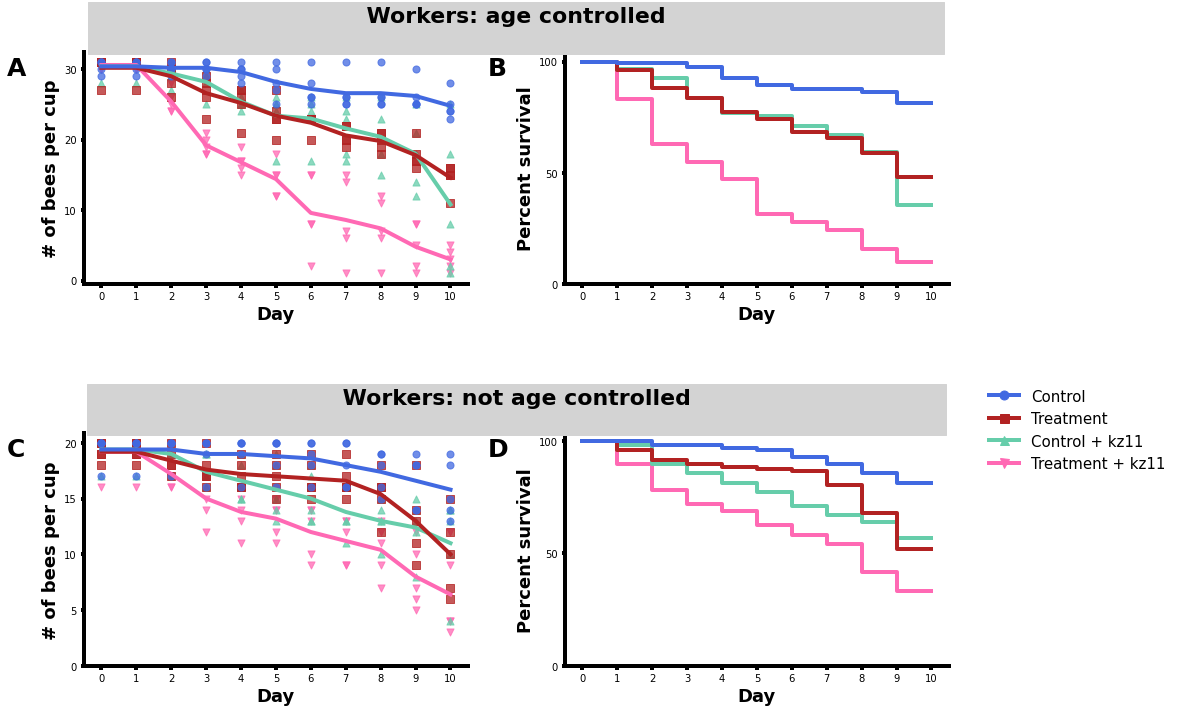

In [28]:
#Plot Fig 5

#specifications for plots
days = 11
rows = 2
cols = 2
shapes = ['o', "s", "^", "v"]
colors = ["royalblue", "firebrick", "mediumaquamarine", "hotpink"]
names = ["Control", "Treat", "Control_KZ11", "Treat_KZ11"]
labels = ["Control", "Treatment", "Control + kz11", "Treatment + kz11"]

# objects of class workers_group 
#ac = age controlled workers, nac = not age controlled workers
ac = workers_group(c_age, names, labels, colors, shapes) 
nac = workers_group(nc_age, names, labels, colors, shapes)
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (17, 10))

#plot data 
#bee counts in left subplots, survival graphs in right subplots
ac.plot_count(ax[0][0], days)
ac.plot_survival(ax[0][1], days)
nac.plot_count(ax[1][0], days)
nac.plot_survival(ax[1][1], days)

#plot legend
marker_specs = [mlines.Line2D([], [], color = colors[i], label = labels[i], 
                              marker = shapes[i])for i in range(len(colors))]
leg = ax[1][1].legend(handles= marker_specs, bbox_to_anchor=(1.6, 1.25), 
                      markerscale = 1.5, fontsize = 15, frameon = False)
for line in leg.get_lines():
    line.set_linewidth(4)


#add subtitles to rows
grid = plt.GridSpec(2, 2)
row_1 = fig.add_subplot(grid[0, ::])
row_1.set_title(f'{"Workers: age controlled" : ^95}\n', 
                fontsize = 22, fontweight = 'heavy', backgroundcolor = 'lightgrey')
row_1.axis('off')
row_2 = fig.add_subplot(grid[1, ::])
row_2.set_title(f'{"Workers: not age controlled" : ^93}\n', 
                fontsize = 22, fontweight = 'heavy', backgroundcolor = 'lightgrey')
row_2.axis('off')

#add subplot labels A, B, C, D
subplot_labels = ['A', 'B', 'C', 'D']
idx = 0
for i in range(rows):
    for j in range(cols):
        ax[i][j].annotate(subplot_labels[idx], xy=(-0.2, 0.9), xycoords="axes fraction", 
                          fontsize = 25, fontweight = 'heavy')
        idx += 1

#match y axes to figure in the paper
ax[0][0].set_yticks(np.arange(0, 40, 10))
ax[0][1].set_yticks(np.arange(0, 150, 50))
ax[1][0].set_yticks(np.arange(0, 25, 5))
ax[1][1].set_yticks(np.arange(0, 150, 50))

#remove top and right border so only x and y axis are showing
for i in range(rows):
    for j in range(cols):
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_linewidth(4)
        ax[i][j].spines['bottom'].set_linewidth(4)
        ax[i][j].tick_params(width = 4)
        
fig.tight_layout()
#plt.savefig("Figure5.pdf", format = "pdf")

______

### Raymann et al. Figure 5:
![figure 5](raymann-figs/figure5.png)

__________

## Figure 6: Bacteria Challenge

In [29]:
imm_c = pd.read_excel("../data/s10.xlsx")
imm_c = process_data(imm_c)
#processed data frame
imm_c.head()

,Bee_number,Start,Stop,Death,Treatment,Cup
1,1,1,2,1,Control,A
2,2,1,2,1,Control,A
3,3,1,11,1,Control,A
4,4,1,11,0,Control,A
5,5,1,11,0,Control,A


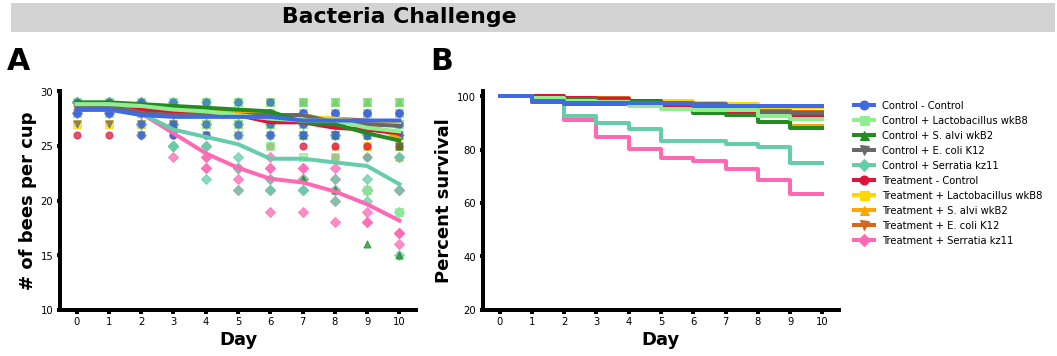

In [30]:
#Plot Fig 6

#figure specifications
days = 11
rows = 1
cols = 2
shapes = ['o', "s", "^", "v", "D"] * 2
colors = ["royalblue", "lightgreen", "forestgreen", 
          "dimgrey", "mediumaquamarine", "crimson", 
          "gold", "orange", "chocolate", "hotpink"]
names = ["Control", "Control_WKB8", "Control_WKB2", 
         "Control_K12", "Control_KZ11", "Treat", 
         "Treat_WKB8", "Treat_WKB2", "Treat_K12", "Treat_KZ11"]
labels = ["Control - Control", "Control + Lactobacillus wkB8",
          "Control + S. alvi wkB2", "Control + E. coli K12", 
          "Control + Serratia kz11", "Treatment - Control", 
          "Treatment + Lactobacillus wkB8", "Treatment + S. alvi wkB2", 
          "Treatment + E. coli K12", "Treatment + Serratia kz11"]

#object of class workers_group
bac_challenge = workers_group(imm_c, names, labels, colors, shapes)
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (15, 5))
space = ' ' * 35
plt.suptitle(f"{space}Bacteria Challenge{space}{space}", 
             fontsize = 22, fontweight = "bold", backgroundcolor = "lightgrey")

bac_challenge.plot_count(ax[0], days)
bac_challenge.plot_survival(ax[1], days)

#remove top and right border so only x and y axis are showing
for i in range(cols):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_linewidth(4)
        ax[i].spines['bottom'].set_linewidth(4)
        ax[i].tick_params(width = 4)
        
#add subplot labels A, B
subplot_labels = ['A', 'B']
idx = 0
for i in range(cols):
        ax[i].annotate(subplot_labels[idx], xy=(-0.15, 1.1), xycoords="axes fraction", 
                          fontsize = 30, fontweight = 'heavy')
        idx += 1

        
#plot legend
marker_specs = [mlines.Line2D([], [], color = colors[i], label = labels[i], 
                              marker = shapes[i])for i in range(len(colors))]
leg = ax[1].legend(handles= marker_specs, bbox_to_anchor=(1.6, 1), markerscale = 1.5, 
                fontsize = 10, frameon = False)
for line in leg.get_lines():
    line.set_linewidth(4)

#match y axes to figure in the paper
ax[0].set_yticks(np.arange(10, 35, 5))
ax[1].set_yticks(np.arange(20, 120, 20))

fig.tight_layout()
#plt.savefig("Figure6.pdf", format = "pdf")

______

### Raymann et al. Figure 6:
![figure 6](raymann-figs/figure6.png)